# Hypothesis Testing: Data Science salary comparision in different place.

## 1. Introduction

Focusing on comparing whether there is a difference data science job's salary in Europe and North America.

Data science is undoubtedly one of the most lucrative career options, ranking among the top three in terms of compensation. However, it's crucial to recognize that pay can vary significantly based on factors such as location, company, and experience level. Therefore, it's essential to weigh all aspects before making a decision about your career path. Entering the field with unrealistic expectations could lead to disappointment.

Geographical location is a crucial factor that can significantly impact your earnings. To highlight the differences in salary across countries, we have provided salary information in USD for selected countries. In this study, we will focus on the disparity in data science job salaries between Europe and North America. Our response variable is the data science job salary, and we will use the difference in mean salary and standard deviation to evaluate the question. To construct the hypothesis test, we will employ both bootstrapping and asymptotics methods.

## 2. Preliminary Results

### 2.1 Data Cleaning

In [8]:
# load necessary packages
library(infer)
library(tidyverse)
library(cowplot)

In [9]:
raw_salary <- read.csv("https://raw.githubusercontent.com/YuluDuan/Hypothesis-Testing-Data-Science-salary-comparison-in-different-location/main/ds_salaries.csv")

head(raw_salary)

,X,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
2,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
3,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
4,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
5,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
6,5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


In this project, as we would focus on analyzing the salary in both Europe and North America, it is important to first filter out all the data that belongs to that two countries and select the necessary column (i.e. location and salary_in_usd).

In [10]:
# by checking all the countries in this list, first find out the countries that belongs to Europe and North America.

na <- c("US", "MX","CA")
eur <- c("DE", "GB", "HU", "FR", "GR", "NL", "AT", "ES", "PT", "DK", "IT", "HR", "LU"
         ,"PL", "RO", "BE", "UA", "RU", "MT", "MD", "SI", "CH", "CZ", "EE", "IE")

In [11]:
# fliter out all rows belong to Europe and North America, save them to a new column called "location"

ds_salary <- raw_salary %>%
    filter(company_location %in% append(na, eur)) %>%
    mutate(location = "North America")

ds_salary$location[ds_salary$company_location %in% eur] <- "Europe"

ds_salary$location <- as.factor(ds_salary$location)

In [13]:
# create the final data set for this project by selecting columns that we would be useful.
ds_final <- ds_salary %>%
    select(salary_in_usd, location)
head(ds_final) # overview of the data

,salary_in_usd,location
,<int>,<fct>
1,79833,Europe
2,109024,Europe
3,150000,North America
4,72000,North America
5,190000,North America
6,35735,Europe


Here, we get our final dataset that would be used to data analysis, and we would now provide overview of the data by providing summary and plots. 

### 2.2 Data Summary and Visualization

Firstly, we would provide summary of the salaries, mainly the sample size for each region, and 5-number-summary for them.

* Table 1. Summary of the wages in two different locations

In [57]:
# create the summary of the data by setting a table with information about salary
ds_eur <- ds_final %>%
    filter(location == "Europe")
ds_na <- ds_final %>%
    filter(location == "North America")

summary_eur <- summary(ds_eur$salary_in_usd)
summary_na <- summary(ds_na$salary_in_usd)

location <- c("Europe", "North America")
mini <- c(summary_eur[1], summary_na[1])
quan_1 <- c(summary_eur[2], summary_na[2])
median <- c(summary_eur[3], summary_na[3])
mean <- c(summary_eur[4], summary_na[4])
quan_3 <- c(summary_eur[5], summary_na[5])
max <- c(summary_eur[6], summary_na[6])
sample_size <- summary(ds_final$location)

table1 <- data.frame(minimum_wage = mini, first_quantile = quan_1, 
                     median_wage = median, mean_wage = mean, third_quantile = quan_3, maximum_wage = max, sample_size)
table1

,minimum_wage,first_quantile,median_wage,mean_wage,third_quantile,maximum_wage,sample_size
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Europe,5882,46597.0,63831,69358.37,87932,230000,157
North America,2859,99037.5,130400,139769.85,170000,600000,388


* Figure 1: Histogram of Salary in Europe and North America

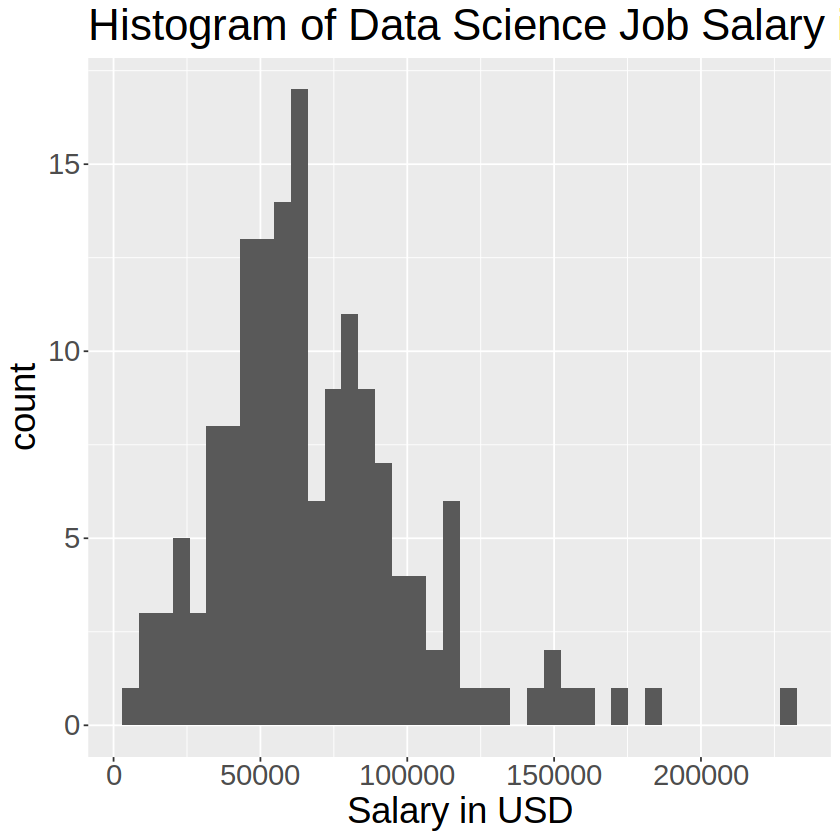

In [6]:
histogram_europe <- ds_final %>%
    filter(location == "Europe") %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(bins = 40) +
    theme(text = element_text(size = 22)) +
    xlab("Salary in USD") + 
    ggtitle("Histogram of Data Science Job Salary in Europe")
histogram_europe

* Figure 2: Histogram of Salary in North America

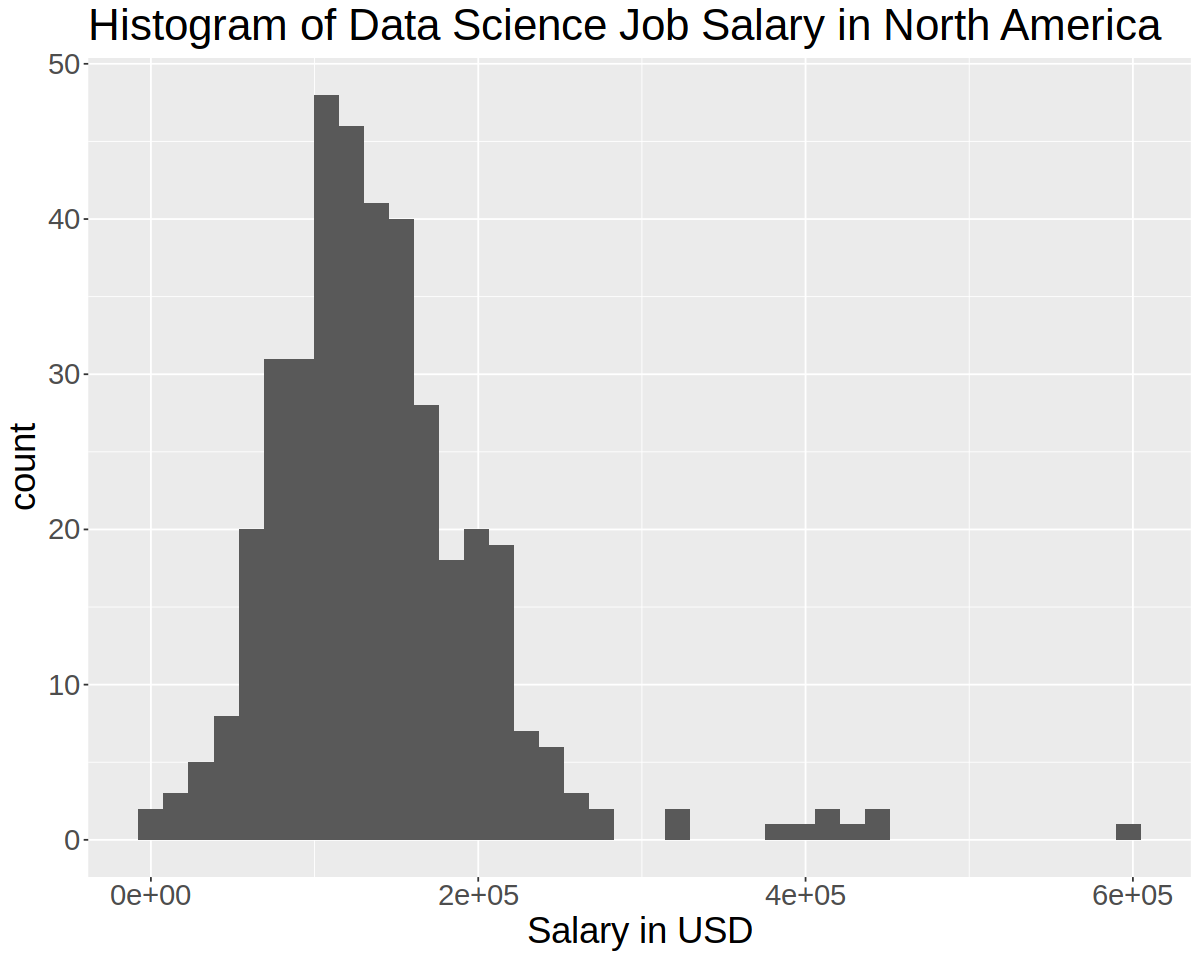

In [13]:
histogram_na <- ds_final %>%
    filter(location == "North America") %>%
    ggplot(aes(x = salary_in_usd),color = 'white') +
    geom_histogram(bins = 40) +
    theme(text = element_text(size = 22)) + 
    xlab("Salary in USD") + 
    ggtitle("Histogram of Data Science Job Salary in North America")
histogram_na

Now, we would get some summary value of the data, mainly the sample size and the estimate of the two parameters, which are population mean salary for data science job in Europe($\mu_e$) and population mean salary for data science job in North America($\mu_{na}$).

* Figure 3: Table of our estimate of true parameters

In [9]:
esti_mu_na <- ds_final %>%
    group_by(location) %>%
    summarize(mean_salary = mean(salary_in_usd), sample_size = n())
esti_mu_na

location,mean_salary,sample_size
<fct>,<dbl>,<int>
Europe,69358.37,157
North America,139769.85,388


For hypothesis testing, solely looking at the mean is not enough as there is also variability in our data. Hence, it would be helpful to pay attention to the sample variance, which we can compare by side-by-side boxplot.

* Figure 4: Boxplot of the salaries in two different regions

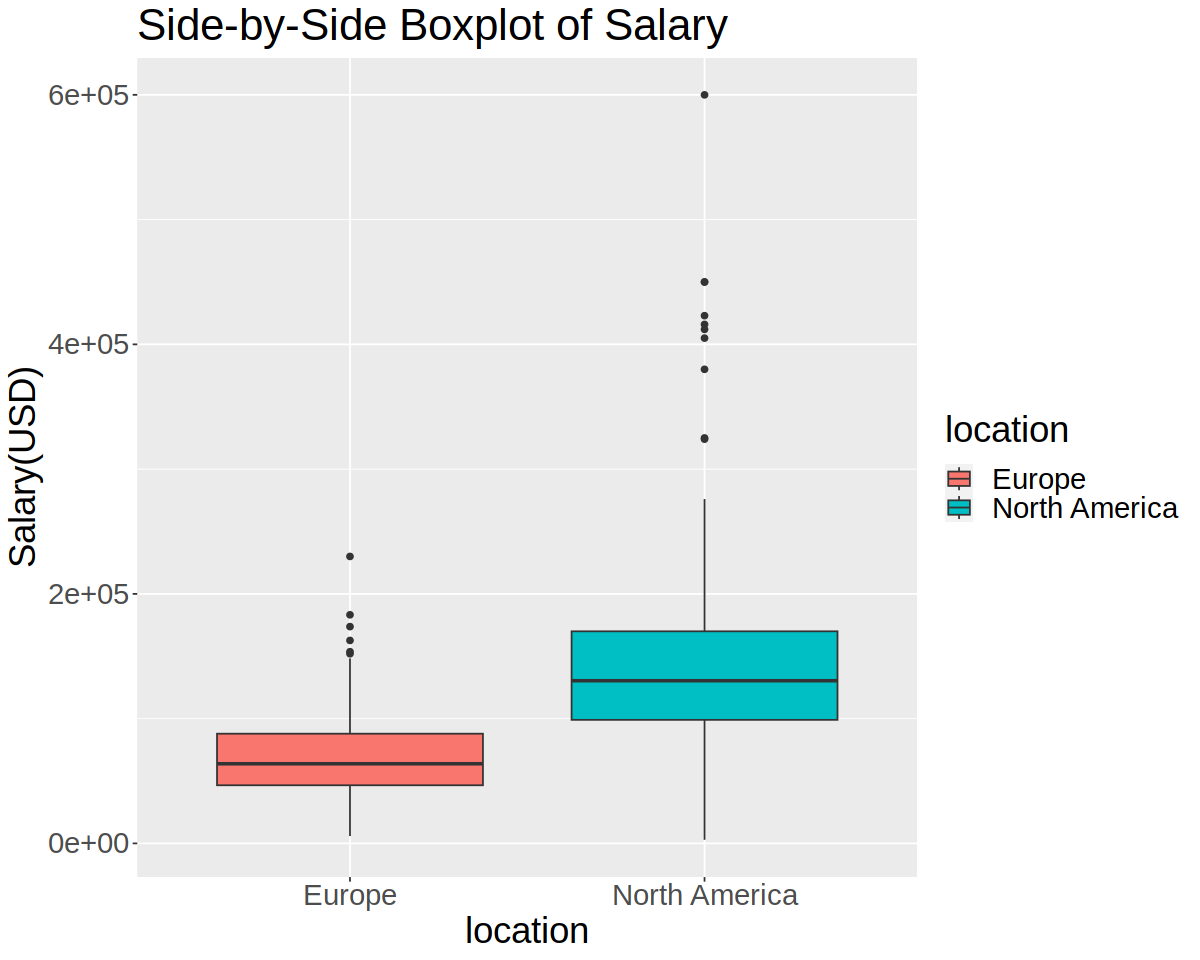

In [11]:
options(repr.plot.width=10, repr.plot.height=8)
boxplot_ds <- ggplot(ds_final, aes(x = location, y = salary_in_usd, fill = location)) +
    geom_boxplot() +
    theme(text = element_text(size = 22)) +
    ylab("Salary(USD)") +
    ggtitle("Side-by-Side Boxplot of Salary")
    
boxplot_ds

## Section 3. Methods: Plan